In [2]:
# Bone Fracture Classification using SVM and HOG Features
# Bài toán phân loại xương gãy sử dụng SVM và trích xuất đặc trưng HOG

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage import io, transform, feature, exposure
from skimage.color import rgb2gray
import cv2
import zipfile
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ===============================
# BƯỚC 1: CÀI ĐẶT VÀ TẢI DỮ LIỆU
# ===============================

# Cài đặt kaggle (nếu chưa có)
!pip install -q kaggle

In [4]:
# Upload file kaggle.json
from google.colab import files
print("Vui lòng upload file kaggle.json:")
uploaded = files.upload()

Vui lòng upload file kaggle.json:


Saving kaggle.json to kaggle.json


In [5]:
# Thiết lập kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Tải dataset
!kaggle datasets download -d bmadushanirodrigo/fracture-multi-region-x-ray-data

# Giải nén dataset
with zipfile.ZipFile('fracture-multi-region-x-ray-data.zip', 'r') as zip_ref:
    zip_ref.extractall()
print("Dataset đã được tải và giải nén thành công!")

Dataset URL: https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data
License(s): ODC Public Domain Dedication and Licence (PDDL)
 98% 472M/481M [00:04<00:00, 122MB/s]
100% 481M/481M [00:04<00:00, 107MB/s]
Dataset đã được tải và giải nén thành công!


In [7]:
# ===============================
# BƯỚC 2: KHÁM PHÁ VÀ TÌM ĐƯỜNG DẪN CHÍNH XÁC
# ===============================

def find_dataset_structure():
    """Tìm và hiển thị cấu trúc thư mục thực tế"""
    print("Khám phá cấu trúc thư mục sau khi giải nén:")

    # Liệt kê tất cả files và folders trong thư mục hiện tại
    current_files = os.listdir('.')
    print("Files/folders trong thư mục hiện tại:", current_files)

    # Tìm thư mục chứa dữ liệu
    possible_paths = [
        "Bone_Fracture_Binary_Classification",
        "fracture-multi-region-x-ray-data",
        "Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification"
    ]

    dataset_path = None
    for path in possible_paths:
        if os.path.exists(path):
            print(f"\nTìm thấy thư mục: {path}")
            # Khám phá cấu trúc bên trong
            try:
                subfolders = os.listdir(path)
                print(f"Nội dung: {subfolders}")

                # Kiểm tra xem có train, test, val không
                if any(folder in subfolders for folder in ['train', 'test', 'val']):
                    dataset_path = path
                    print(f"✓ Đây là thư mục dataset chính: {path}")
                    break
                else:
                    # Kiểm tra thêm một cấp
                    for subfolder in subfolders:
                        subfolder_path = os.path.join(path, subfolder)
                        if os.path.isdir(subfolder_path):
                            try:
                                nested_content = os.listdir(subfolder_path)
                                print(f"  {subfolder}/: {nested_content}")
                                if any(folder in nested_content for folder in ['train', 'test', 'val']):
                                    dataset_path = subfolder_path
                                    print(f"✓ Tìm thấy dataset trong: {subfolder_path}")
                                    break
                            except:
                                continue
            except Exception as e:
                print(f"Không thể đọc thư mục {path}: {e}")

    return dataset_path

In [8]:

def explore_dataset(base_path):
    """Khám phá cấu trúc dataset với đường dẫn chính xác"""
    if not base_path:
        print("Không tìm thấy thư mục dataset!")
        return False

    print(f"\nKhám phá dataset tại: {base_path}")

    for subset in ['train', 'test', 'val']:
        subset_path = os.path.join(base_path, subset)
        if os.path.exists(subset_path):
            print(f"\n{subset.upper()} SET tại {subset_path}:")

            # Liệt kê các thư mục con
            subdirs = os.listdir(subset_path)
            print(f"  Thư mục con: {subdirs}")

            # Đếm ảnh trong mỗi class
            for class_name in subdirs:
                class_path = os.path.join(subset_path, class_name)
                if os.path.isdir(class_path):
                    try:
                        files = [f for f in os.listdir(class_path)
                                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                        print(f"  - {class_name}: {len(files)} ảnh")

                        # Hiển thị một vài tên file mẫu
                        if files:
                            print(f"    Ví dụ: {files[:3]}")
                    except Exception as e:
                        print(f"  - Lỗi đọc {class_name}: {e}")
        else:
            print(f"\n{subset.upper()} SET: Không tồn tại tại {subset_path}")

    return True


In [9]:
# Tìm đường dẫn chính xác
dataset_base_path = find_dataset_structure()
if dataset_base_path:
    explore_success = explore_dataset(dataset_base_path)
else:
    print("CẢNH BÁO: Không tìm thấy cấu trúc dataset mong đợi!")
    # Hiển thị toàn bộ cấu trúc để debug
    print("\nCấu trúc thư mục hiện tại:")
    for root, dirs, files in os.walk('.'):
        level = root.replace('.', '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Chỉ hiển thị 5 file đầu
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... và {len(files)-5} file khác")

Khám phá cấu trúc thư mục sau khi giải nén:
Files/folders trong thư mục hiện tại: ['.config', 'fracture-multi-region-x-ray-data.zip', 'kaggle.json', 'Bone_Fracture_Binary_Classification', 'README.dataset.txt', 'sample_data']

Tìm thấy thư mục: Bone_Fracture_Binary_Classification
Nội dung: ['Bone_Fracture_Binary_Classification']
  Bone_Fracture_Binary_Classification/: ['val', 'test', 'train']
✓ Tìm thấy dataset trong: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification

Tìm thấy thư mục: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification
Nội dung: ['val', 'test', 'train']
✓ Đây là thư mục dataset chính: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification

Khám phá dataset tại: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification

TRAIN SET tại Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train:
  Thư mục con: ['fractured', 'not fractured']
  - fractured: 4606 ảnh
    Ví dụ: ['6-rot

In [10]:
# ===============================
# BƯỚC 3: TIỀN XỬ LÝ VÀ TRÍCH XUẤT ĐẶC TRƯNG HOG
# ===============================

def preprocess_image(image_path, target_size=(128, 128)):
    """
    Tiền xử lý ảnh:
    - Đọc ảnh
    - Chuyển về grayscale
    - Resize
    - Cân bằng histogram
    """
    try:
        # Đọc ảnh
        image = io.imread(image_path)

        # Chuyển về grayscale nếu cần
        if len(image.shape) == 3:
            image = rgb2gray(image)

        # Resize ảnh
        image = transform.resize(image, target_size, anti_aliasing=True)

        # Cân bằng histogram để tăng cường contrast
        image = exposure.equalize_adapthist(image)

        return image
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {image_path}: {e}")
        return None

In [11]:
def extract_hog_features(image, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2)):
    """
    Trích xuất đặc trưng HOG (Histogram of Oriented Gradients)

    Parameters:
    - orientations: Số hướng gradient
    - pixels_per_cell: Kích thước cell
    - cells_per_block: Số cell trong một block
    """
    try:
        hog_features = feature.hog(
            image,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            visualize=False,
            feature_vector=True
        )
        return hog_features
    except Exception as e:
        print(f"Lỗi khi trích xuất HOG: {e}")
        return None

In [12]:
def load_and_process_data(base_path, subset_name, target_size=(128, 128)):
    """
    Tải và xử lý dữ liệu từ một subset với kiểm tra đường dẫn linh hoạt
    """
    subset_path = os.path.join(base_path, subset_name)

    if not os.path.exists(subset_path):
        print(f"CẢNH BÁO: Không tìm thấy thư mục {subset_path}")
        return np.array([]), np.array([]), np.array([])

    print(f"\nĐang xử lý {subset_name} từ: {subset_path}")

    images = []
    labels = []
    hog_features = []

    # Lấy danh sách các thư mục con (classes)
    try:
        class_folders = [f for f in os.listdir(subset_path)
                        if os.path.isdir(os.path.join(subset_path, f))]
        print(f"Tìm thấy các class: {class_folders}")
    except Exception as e:
        print(f"Lỗi khi đọc thư mục {subset_path}: {e}")
        return np.array([]), np.array([]), np.array([])

    # Xử lý từng class
    for class_name in class_folders:
        class_path = os.path.join(subset_path, class_name)

        try:
            # Lấy danh sách file ảnh
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

            print(f"Đang xử lý {len(image_files)} ảnh từ class '{class_name}'...")

            processed_count = 0
            for filename in tqdm(image_files, desc=f"Processing {class_name}"):
                image_path = os.path.join(class_path, filename)

                try:
                    processed_image = preprocess_image(image_path, target_size)

                    if processed_image is not None:
                        hog_feat = extract_hog_features(processed_image)
                        if hog_feat is not None:
                            images.append(processed_image)
                            labels.append(class_name)
                            hog_features.append(hog_feat)
                            processed_count += 1
                except Exception as e:
                    print(f"Lỗi xử lý {image_path}: {e}")
                    continue

            print(f"  → Đã xử lý thành công {processed_count}/{len(image_files)} ảnh từ '{class_name}'")

        except Exception as e:
            print(f"Lỗi khi xử lý class {class_name}: {e}")
            continue

    print(f"Tổng cộng đã tải {len(images)} ảnh từ {subset_name}")

    if len(images) == 0:
        print(f"CẢNH BÁO: Không tải được ảnh nào từ {subset_name}!")
        return np.array([]), np.array([]), np.array([])

    return np.array(images), np.array(labels), np.array(hog_features)

In [13]:
# Tải dữ liệu với đường dẫn đã được xác định
if not dataset_base_path:
    print("DỪNG: Không thể tìm thấy dataset. Vui lòng kiểm tra lại!")
    print("Có thể bạn cần:")
    print("1. Kiểm tra tên dataset trên Kaggle có chính xác không")
    print("2. Xem lại cấu trúc thư mục sau khi giải nén")
else:
    print(f"\nBắt đầu tải và xử lý dữ liệu từ: {dataset_base_path}")

    # Tải dữ liệu train
    X_train_images, y_train, X_train_hog = load_and_process_data(dataset_base_path, 'train')
    if len(X_train_images) > 0:
        print(f"✓ Train set: {len(X_train_images)} ảnh, HOG features shape: {X_train_hog.shape}")
    else:
        print("✗ Không tải được dữ liệu train!")

    # Tải dữ liệu test
    X_test_images, y_test, X_test_hog = load_and_process_data(dataset_base_path, 'test')
    if len(X_test_images) > 0:
        print(f"✓ Test set: {len(X_test_images)} ảnh, HOG features shape: {X_test_hog.shape}")
    else:
        print("✗ Không tải được dữ liệu test!")

    # Tải dữ liệu validation
    X_val_images, y_val, X_val_hog = load_and_process_data(dataset_base_path, 'val')
    if len(X_val_images) > 0:
        print(f"✓ Validation set: {len(X_val_images)} ảnh, HOG features shape: {X_val_hog.shape}")
    else:
        print("✗ Không tải được dữ liệu validation!")

    # Kiểm tra xem có đủ dữ liệu để tiếp tục không
    if len(X_train_images) == 0:
        print("\nKHÔNG THỂ TIẾP TỤC: Không có dữ liệu train!")
        print("Vui lòng kiểm tra lại dataset và đường dẫn.")
    else:
        print(f"\n✓ Tải dữ liệu thành công!")
        print(f"  - Classes tìm thấy: {np.unique(y_train)}")
        print(f"  - Tổng số ảnh train: {len(X_train_images)}")
        print(f"  - Tổng số ảnh test: {len(X_test_images)}")
        print(f"  - Tổng số ảnh validation: {len(X_val_images)}")


Bắt đầu tải và xử lý dữ liệu từ: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification

Đang xử lý train từ: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train
Tìm thấy các class: ['fractured', 'not fractured']
Đang xử lý 4606 ảnh từ class 'fractured'...


Processing fractured:   6%|▌         | 276/4606 [00:12<02:20, 30.74it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/anterior_wedge_fracture_at_L1.png: the input array must have size 3 along `channel_axis`, got (384, 384, 4)


Processing fractured:  12%|█▏        | 561/4606 [00:19<01:29, 45.17it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/Fig-A6-Fracture-X-ray-image-of-an-oblique-fracture-of-the-left-humerus.png: the input array must have size 3 along `channel_axis`, got (1063, 432, 4)


Processing fractured:  21%|██▏       | 984/4606 [00:30<01:13, 49.41it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/159.jpg: output_shape length cannot be smaller than the image number of dimensions


Processing fractured:  24%|██▎       | 1090/4606 [00:32<00:55, 63.01it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/116.jpg: the input array must have size 3 along `channel_axis`, got (350, 290, 4)


Processing fractured:  25%|██▌       | 1160/4606 [00:33<00:51, 67.44it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/4 (1).jpg: the input array must have size 3 along `channel_axis`, got (375, 257, 4)


Processing fractured:  39%|███▊      | 1784/4606 [00:51<01:39, 28.23it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/2.jpg: output_shape length cannot be smaller than the image number of dimensions


Processing fractured:  53%|█████▎    | 2444/4606 [01:10<00:36, 59.53it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/17(1).jpg: the input array must have size 3 along `channel_axis`, got (350, 290, 4)


Processing fractured:  56%|█████▌    | 2570/4606 [01:14<00:39, 51.80it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/43.jpg: the input array must have size 3 along `channel_axis`, got (375, 257, 4)


Processing fractured:  61%|██████    | 2810/4606 [01:21<01:18, 22.90it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/26(1).jpg: output_shape length cannot be smaller than the image number of dimensions


Processing fractured:  68%|██████▊   | 3110/4606 [01:31<00:28, 52.62it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/220px-MalletFinger.PNG.jpg: the input array must have size 3 along `channel_axis`, got (319, 220, 4)


Processing fractured:  68%|██████▊   | 3125/4606 [01:32<00:26, 55.38it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/57.jpg: the input array must have size 3 along `channel_axis`, got (460, 393, 4)


Processing fractured:  77%|███████▋  | 3525/4606 [01:44<00:25, 43.04it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/68.jpg: the input array must have size 3 along `channel_axis`, got (404, 198, 4)


Processing fractured:  82%|████████▏ | 3799/4606 [01:53<00:20, 40.16it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/type20i.lateral.jpg: the input array must have size 3 along `channel_axis`, got (255, 500, 4)
Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/tibia20path20fx.jpg: the input array must have size 3 along `channel_axis`, got (450, 296, 4)


Processing fractured:  84%|████████▍ | 3873/4606 [01:56<00:12, 57.00it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/120.jpg: the input array must have size 3 along `channel_axis`, got (377, 265, 4)


Processing fractured:  92%|█████████▏| 4245/4606 [02:09<00:06, 55.61it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/190.jpg: the input array must have size 3 along `channel_axis`, got (706, 441, 4)


Processing fractured: 100%|██████████| 4606/4606 [02:21<00:00, 32.44it/s]


  → Đã xử lý thành công 4590/4606 ảnh từ 'fractured'
Đang xử lý 4640 ảnh từ class 'not fractured'...


Processing not fractured:  15%|█▌        | 714/4640 [00:20<01:24, 46.70it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004149.jpg: image file is truncated (33 bytes not processed)


Processing not fractured:  26%|██▌       | 1214/4640 [00:31<00:59, 57.62it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004143.jpg: image file is truncated (10 bytes not processed)


Processing not fractured:  38%|███▊      | 1783/4640 [00:48<02:45, 17.31it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004134.jpg: image file is truncated (1 bytes not processed)


Processing not fractured:  45%|████▌     | 2097/4640 [00:54<00:37, 68.71it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004347.jpg: image file is truncated (40 bytes not processed)


Processing not fractured:  47%|████▋     | 2180/4640 [00:55<00:35, 68.79it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004148.jpg: image file is truncated (14 bytes not processed)


Processing not fractured:  49%|████▉     | 2294/4640 [00:57<00:34, 68.16it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004308.jpg: image file is truncated (40 bytes not processed)


Processing not fractured: 100%|██████████| 4640/4640 [02:01<00:00, 38.20it/s]


  → Đã xử lý thành công 4634/4640 ảnh từ 'not fractured'
Tổng cộng đã tải 9224 ảnh từ train
✓ Train set: 9224 ảnh, HOG features shape: (9224, 8100)

Đang xử lý test từ: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test
Tìm thấy các class: ['fractured', 'not fractured']
Đang xử lý 238 ảnh từ class 'fractured'...


Processing fractured: 100%|██████████| 238/238 [00:13<00:00, 17.28it/s]


  → Đã xử lý thành công 238/238 ảnh từ 'fractured'
Đang xử lý 268 ảnh từ class 'not fractured'...


Processing not fractured:  14%|█▍        | 38/268 [00:06<00:23,  9.97it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004149.jpg: image file is truncated (33 bytes not processed)


Processing not fractured:  25%|██▌       | 68/268 [00:09<00:09, 20.23it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004143.jpg: image file is truncated (10 bytes not processed)


Processing not fractured:  40%|███▉      | 106/268 [00:14<00:16, 10.04it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004134.jpg: image file is truncated (1 bytes not processed)


Processing not fractured:  47%|████▋     | 126/268 [00:15<00:07, 18.21it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004347.jpg: image file is truncated (40 bytes not processed)
Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004148.jpg: image file is truncated (14 bytes not processed)
Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004308.jpg: image file is truncated (40 bytes not processed)


Processing not fractured: 100%|██████████| 268/268 [00:37<00:00,  7.09it/s]


  → Đã xử lý thành công 262/268 ảnh từ 'not fractured'
Tổng cộng đã tải 500 ảnh từ test
✓ Test set: 500 ảnh, HOG features shape: (500, 8100)

Đang xử lý val từ: Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val
Tìm thấy các class: ['fractured', 'not fractured']
Đang xử lý 337 ảnh từ class 'fractured'...


Processing fractured:   6%|▌         | 19/337 [00:00<00:15, 19.93it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/ea2cb099-e4ab-4c7a-a310-1699b9242b9f-1649988191446.png: the input array must have size 3 along `channel_axis`, got (516, 770, 4)


Processing fractured:  14%|█▎        | 46/337 [00:03<00:20, 14.48it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/000002.png: the input array must have size 3 along `channel_axis`, got (480, 480, 4)


Processing fractured:  33%|███▎      | 112/337 [00:09<00:28,  7.98it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/94f6a-pclavulsion1a.png: the input array must have size 3 along `channel_axis`, got (1600, 1181, 4)


Processing fractured:  37%|███▋      | 125/337 [00:09<00:12, 16.93it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/ap20humerus20radiograph20metastases20fracture.jpg: the input array must have size 3 along `channel_axis`, got (450, 340, 4)


Processing fractured:  65%|██████▌   | 220/337 [00:19<00:05, 19.69it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/a278b017-807e-4a0e-9273-908eafeb7715-1649987901703.png: the input array must have size 3 along `channel_axis`, got (589, 491, 4)


Processing fractured:  80%|███████▉  | 269/337 [00:25<00:08,  7.75it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/tibia20path20fx.jpg: the input array must have size 3 along `channel_axis`, got (450, 296, 4)


Processing fractured:  96%|█████████▌| 323/337 [00:27<00:00, 32.70it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/8-2010728x6.png: the input array must have size 3 along `channel_axis`, got (287, 236, 4)


Processing fractured: 100%|██████████| 337/337 [00:27<00:00, 12.08it/s]


  → Đã xử lý thành công 330/337 ảnh từ 'fractured'
Đang xử lý 492 ảnh từ class 'not fractured'...


Processing not fractured:  15%|█▌        | 74/492 [00:08<00:24, 16.98it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004149.jpg: image file is truncated (33 bytes not processed)


Processing not fractured:  26%|██▌       | 128/492 [00:10<00:08, 43.06it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004143.jpg: image file is truncated (10 bytes not processed)


Processing not fractured:  39%|███▉      | 194/492 [00:16<00:32,  9.16it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004134.jpg: image file is truncated (1 bytes not processed)


Processing not fractured:  48%|████▊     | 238/492 [00:17<00:07, 34.17it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004347.jpg: image file is truncated (40 bytes not processed)
Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004148.jpg: image file is truncated (14 bytes not processed)


Processing not fractured:  50%|████▉     | 245/492 [00:17<00:06, 40.05it/s]

Lỗi khi xử lý ảnh Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004308.jpg: image file is truncated (40 bytes not processed)


Processing not fractured: 100%|██████████| 492/492 [00:41<00:00, 11.89it/s]

  → Đã xử lý thành công 486/492 ảnh từ 'not fractured'
Tổng cộng đã tải 816 ảnh từ val
✓ Validation set: 816 ảnh, HOG features shape: (816, 8100)

✓ Tải dữ liệu thành công!
  - Classes tìm thấy: ['fractured' 'not fractured']
  - Tổng số ảnh train: 9224
  - Tổng số ảnh test: 500
  - Tổng số ảnh validation: 816


In [14]:
# ===============================
# BƯỚC 4: CHUẨN HÓA DỮ LIỆU (chỉ chạy nếu có dữ liệu)
# ===============================

if 'X_train_images' in locals() and len(X_train_images) > 0:
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

    # Chuẩn hóa HOG features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_hog)

    # Chỉ chuẩn hóa test và val nếu có dữ liệu
    if len(X_test_images) > 0:
        y_test_encoded = label_encoder.transform(y_test)
        X_test_scaled = scaler.transform(X_test_hog)
    else:
        print("Cảnh báo: Không có dữ liệu test")
        X_test_scaled = np.array([])
        y_test_encoded = np.array([])

    if len(X_val_images) > 0:
        y_val_encoded = label_encoder.transform(y_val)
        X_val_scaled = scaler.transform(X_val_hog)
    else:
        print("Cảnh báo: Không có dữ liệu validation")
        X_val_scaled = np.array([])
        y_val_encoded = np.array([])

    print("Chuẩn hóa dữ liệu hoàn thành!")
    print(f"Train features shape: {X_train_scaled.shape}")
    if len(X_test_scaled) > 0:
        print(f"Test features shape: {X_test_scaled.shape}")
    if len(X_val_scaled) > 0:
        print(f"Validation features shape: {X_val_scaled.shape}")
else:
    print("DỪNG: Không có dữ liệu để chuẩn hóa!")

Label mapping: {np.str_('fractured'): np.int64(0), np.str_('not fractured'): np.int64(1)}
Chuẩn hóa dữ liệu hoàn thành!
Train features shape: (9224, 8100)
Test features shape: (500, 8100)
Validation features shape: (816, 8100)


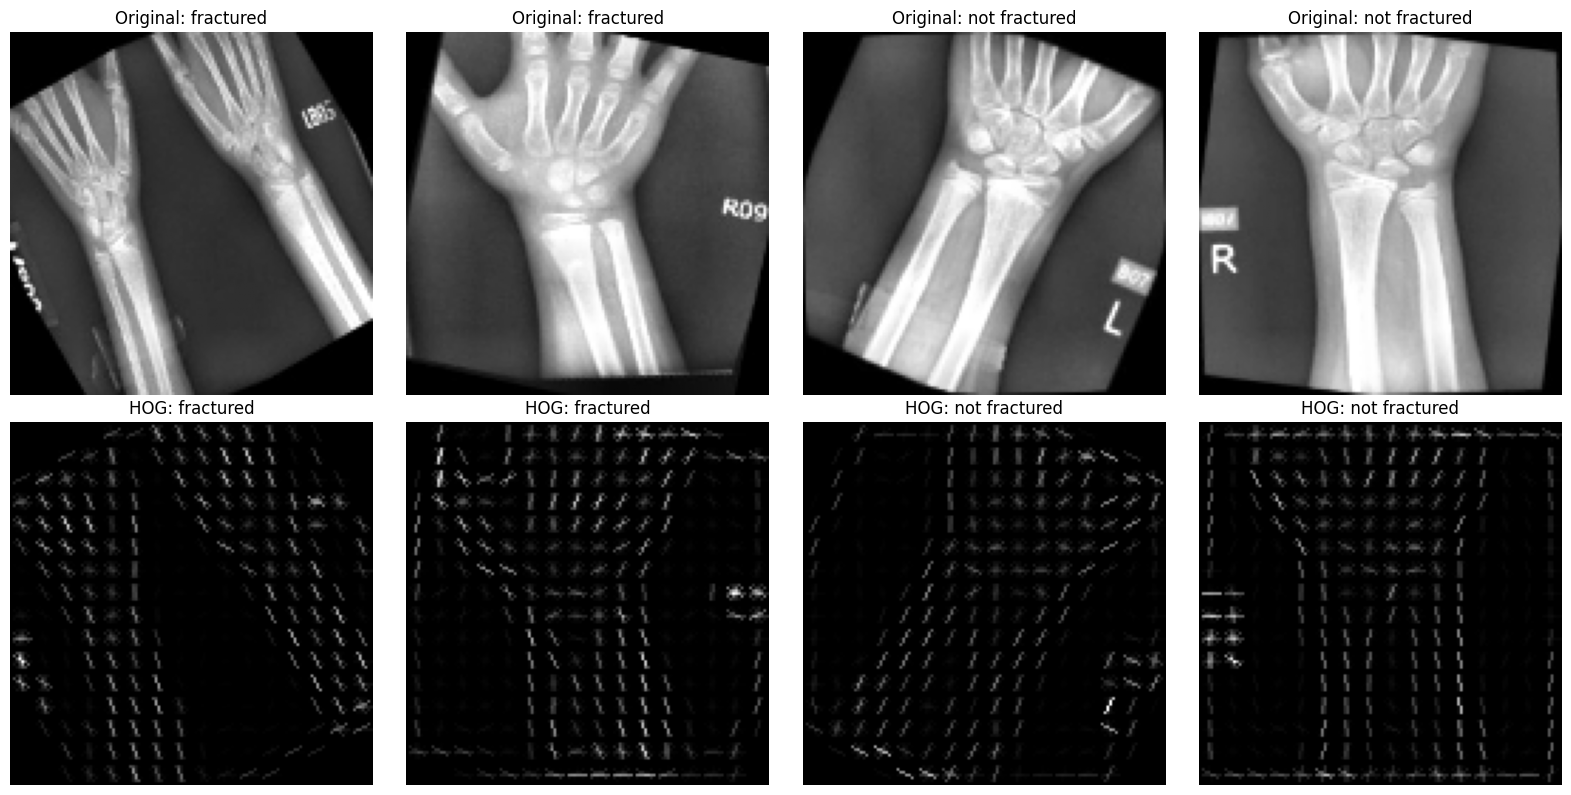

In [15]:
# ===============================
# BƯỚC 5: HIỂN THỊ MẪU DỮ LIỆU
# ===============================

def visualize_samples():
    """Hiển thị một số mẫu dữ liệu và HOG features"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # Lấy một số mẫu từ mỗi class
    fractured_indices = np.where(y_train == 'fractured')[0][:2]
    not_fractured_indices = np.where(y_train == 'not fractured')[0][:2]

    sample_indices = np.concatenate([fractured_indices, not_fractured_indices])

    for i, idx in enumerate(sample_indices):
        # Hiển thị ảnh gốc
        axes[0, i].imshow(X_train_images[idx], cmap='gray')
        axes[0, i].set_title(f'Original: {y_train[idx]}')
        axes[0, i].axis('off')

        # Hiển thị HOG visualization
        hog_image = feature.hog(X_train_images[idx], orientations=9,
                              pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                              visualize=True, feature_vector=False)[1]

        axes[1, i].imshow(hog_image, cmap='gray')
        axes[1, i].set_title(f'HOG: {y_train[idx]}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples()

In [24]:
# ===============================
# BƯỚC 6: HUẤN LUYỆN MÔ HÌNH SVM (TỐI ƯU HÓA NÂNG CAO)
# ===============================

import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier # Import SGDClassifier

def optimize_svm_training(X_train_scaled, y_train_encoded, timeout_minutes=15):
    """
    Tối ưu hóa quá trình huấn luyện SVM với nhiều chiến lược
    """
    print("=== BẮT ĐẦU TỐI ƯU HÓA HUẤN LUYỆN SVM ===")

    # CHIẾN LƯỢC 1: Giảm kích thước dữ liệu nếu quá lớn
    n_samples, n_features = X_train_scaled.shape
    print(f"Dữ liệu gốc: {n_samples} samples, {n_features} features")

    # Nếu có quá nhiều samples (>5000), lấy subset để huấn luyện nhanh hơn
    if n_samples > 5000:
        print(f"Dataset lớn ({n_samples} samples), sẽ sử dụng subset để tăng tốc...")

        # Stratified sampling để giữ tỷ lệ các class
        from sklearn.model_selection import StratifiedShuffleSplit
        sss = StratifiedShuffleSplit(n_splits=1, train_size=0.3, random_state=42)
        subset_idx, _ = next(sss.split(X_train_scaled, y_train_encoded))

        X_subset = X_train_scaled[subset_idx]
        y_subset = y_train_encoded[subset_idx]
        print(f"Sử dụng subset: {len(X_subset)} samples")

        use_subset = True
    else:
        X_subset = X_train_scaled
        y_subset = y_train_encoded
        use_subset = False

    # CHIẾN LƯỢC 2: Giảm chiều dữ liệu với PCA nếu có quá nhiều features
    if n_features > 1000:
        print(f"Số features lớn ({n_features}), áp dụng PCA để giảm chiều...")

        # Giữ 95% variance
        pca = PCA(n_components=0.95, random_state=42)
        X_subset_pca = pca.fit_transform(X_subset)

        print(f"PCA giảm từ {n_features} xuống {X_subset_pca.shape[1]} features")
        print(f"Variance được giữ lại: {pca.explained_variance_ratio_.sum():.3f}")

        X_train_final = X_subset_pca
        use_pca = True
    else:
        X_train_final = X_subset
        pca = None
        use_pca = False

    # CHIẾN LƯỢC 3: Thử Linear SVM trước (nhanh nhất)
    print("\n1. KIỂM TRA LINEAR SVM (nhanh nhất)...")
    start_time = time.time()

    # Use SVC with probability=True to allow predict_proba later if chosen
    linear_svm = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
    linear_svm.fit(X_train_final, y_subset)

    linear_time = time.time() - start_time
    print(f"Linear SVM training time: {linear_time:.2f} seconds")

    # Quick validation
    from sklearn.model_selection import cross_val_score
    # Use cross_val_score on the subset for quicker check
    linear_scores = cross_val_score(linear_svm, X_train_final, y_subset, cv=3, scoring='accuracy')
    linear_mean_score = linear_scores.mean()
    print(f"Linear SVM CV score (subset): {linear_mean_score:.4f} ± {linear_scores.std():.4f}")

    # CHIẾN LƯỢC 4: Nếu Linear SVM đạt kết quả tốt (>85%), có thể dừng ở đây
    # Note: This threshold might need adjustment based on dataset difficulty
    if linear_mean_score > 0.85:
        print(f"✅ Linear SVM đạt {linear_mean_score:.4f} - KẾT QUẢ TỐT!")
        print("Khuyến nghị: Sử dụng Linear SVM làm mô hình chính.")
        best_model = linear_svm
        best_score = linear_mean_score

        # Train again on full data if subset was used
        if use_subset:
            print("Training Linear SVM trên toàn bộ dữ liệu...")
            X_full_final = pca.transform(X_train_scaled) if use_pca else X_train_scaled
            linear_svm.fit(X_full_final, y_train_encoded)

        return {
            'model': linear_svm,
            'pca': pca,
            'best_score': best_score,
            'kernel': 'linear',
            'training_time': linear_time,
            'used_subset': use_subset,
            'used_pca': use_pca
        }

    # CHIẾN LƯỢC 5: RandomizedSearchCV thay vì GridSearchCV (nhanh hơn nhiều)
    print(f"\n2. RANDOMIZED SEARCH (nhanh hơn Grid Search)...")

    # Tham số search space
    param_distributions = {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    }

    # RandomizedSearchCV with fewer iterations
    # Ensure probability=True is set for SVC to get predict_proba
    svm_model = SVC(random_state=42, probability=True)

    random_search = RandomizedSearchCV(
        svm_model,
        param_distributions,
        n_iter=10,  # Try 10 combinations instead of all
        cv=3,       # 3-fold CV instead of 5
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    print("Bắt đầu Randomized Search...")
    start_time = time.time()

    try:
        # Set timeout
        import signal

        def timeout_handler(signum, frame):
            raise TimeoutError("Training timeout!")

        #signal.signal(signal.SIGALRM, timeout_handler)
        #signal.alarm(timeout_minutes * 60)  # Convert to seconds
        # Disabling signal based timeout for Colab/certain environments where it might be unstable

        random_search.fit(X_train_final, y_subset)

        #signal.alarm(0)  # Cancel alarm

        search_time = time.time() - start_time
        print(f"Randomized Search completed in {search_time:.2f} seconds")
        print(f"Best parameters: {random_search.best_params_}")
        print(f"Best CV score (subset): {random_search.best_score_:.4f}")

        best_model = random_search.best_estimator_
        best_score = random_search.best_score_

    except (TimeoutError, Exception) as e:
        #signal.alarm(0)
        print(f"Randomized Search timeout hoặc lỗi: {e}")
        print("Fallback to Linear SVM...")
        best_model = linear_svm # Use the initial linear_svm trained on subset
        best_score = linear_mean_score
        search_time = time.time() - start_time # Approximate time

    # CHIẾN LƯỢC 6: Train mô hình tốt nhất trên toàn bộ dữ liệu
    # Only retrain if the best_model is from the search and subset was used
    if use_subset and type(best_model) == type(svm_model): # Check if it's the model from RandomizedSearch
        print(f"\n3. TRAINING MÔ HÌNH TỐT NHẤT TRÊN TOÀN BỘ DỮ LIỆU...")

        if use_pca:
            X_full_final = pca.transform(X_train_scaled)
        else:
            X_full_final = X_train_scaled

        start_time = time.time()
        try:
            #signal.signal(signal.SIGALRM, timeout_handler)
            #signal.alarm(timeout_minutes * 30)  # Half timeout for final training
            # Disabling signal based timeout

            best_model.fit(X_full_final, y_train_encoded)

            #signal.alarm(0)
            final_time = time.time() - start_time
            print(f"Final training completed in {final_time:.2f} seconds")
            # Update training time to reflect the final full training
            total_training_time = final_time
        except (TimeoutError, Exception) as e:
            #signal.alarm(0)
            print(f"Final training timeout: {e}")
            print("Sử dụng mô hình đã train trên subset...")
            total_training_time = search_time # Use search time if final training failed

    else: # If no subset was used, or fallback to linear_svm (already trained on full data if no subset)
         total_training_time = search_time if 'search_time' in locals() else linear_time


    return {
        'model': best_model,
        'pca': pca,
        'best_score': best_score,
        'kernel': getattr(best_model, 'kernel', 'unknown'),
        'training_time': total_training_time,
        'used_subset': use_subset,
        'used_pca': use_pca
    }

# CHIẾN LƯỢC 7: Huấn luyện nhanh với SGD (Stochastic Gradient Descent)
def train_sgd_alternative(X_train_scaled, y_train_encoded):
    """
    Alternative: SGD Classifier - rất nhanh cho dataset lớn
    """
    print("\n=== ALTERNATIVE: SGD CLASSIFIER (RẤT NHANH) ===")

    from sklearn.linear_model import SGDClassifier

    # SGD with SVM loss (equivalent to Linear SVM but much faster)
    # Note: SGDClassifier with loss='hinge' does NOT support predict_proba
    sgd_svm = SGDClassifier(
        loss='hinge',  # SVM loss
        learning_rate='adaptive',
        eta0=0.01,
        max_iter=1000,
        random_state=42,
        n_jobs=-1,
        early_stopping=True, # Add early stopping
        validation_fraction=0.1, # Use 10% for validation
        n_iter_no_change=10 # Stop if score doesn't improve for 10 iterations
    )

    start_time = time.time()
    sgd_svm.fit(X_train_scaled, y_train_encoded)
    sgd_time = time.time() - start_time

    print(f"SGD training time: {sgd_time:.2f} seconds")

    # Quick evaluation
    # Use decision_function for evaluation metrics if predict_proba is not available
    # Note: cross_val_score often defaults to 'accuracy' which uses predict/decision_function
    try:
        sgd_scores = cross_val_score(sgd_svm, X_train_scaled, y_train_encoded, cv=3, scoring='accuracy')
        print(f"SGD CV score: {sgd_scores.mean():.4f} ± {sgd_scores.std():.4f}")
        sgd_score = sgd_scores.mean()
    except Exception as e:
        print(f"Error during SGD cross-validation: {e}. Evaluating on train set...")
        # Fallback to simple train set accuracy if CV fails
        y_pred_train_sgd = sgd_svm.predict(X_train_scaled)
        sgd_score = accuracy_score(y_train_encoded, y_pred_train_sgd)
        print(f"SGD Train Accuracy: {sgd_score:.4f}")


    return sgd_svm, sgd_score

# ===============================
# CHẠY TỐI ƯU HÓA
# ===============================

if 'X_train_scaled' in locals() and len(X_train_scaled) > 0:
    print("Bắt đầu quá trình tối ưu hóa huấn luyện SVM...")

    # Option 1: Thử SGD trước (siêu nhanh)
    sgd_model, sgd_score = train_sgd_alternative(X_train_scaled, y_train_encoded)

    # Option 2: Tối ưu hóa SVM
    # Pass the original data if subsetting is handled inside optimize_svm_training
    result = optimize_svm_training(X_train_scaled, y_train_encoded, timeout_minutes=10)

    # So sánh và chọn mô hình tốt nhất
    print(f"\n{'='*60}")
    print("SO SÁNH KẾT QUẢ:")
    print(f"SGD Score: {sgd_score:.4f}")
    print(f"Optimized SVM Score: {result['best_score']:.4f}")
    print(f"{'='*60}")

    # Choose SGD if its score is close and it's much faster (optional, keep based on score difference)
    if sgd_score >= result['best_score'] - 0.01 and type(result['model']).__name__ != 'SGDClassifier': # Small tolerance for SGD being slightly lower
         print("✅ Chọn SGD Classifier (nhanh hơn và kết quả tương đương)")
         best_svm = sgd_model
         best_score = sgd_score
         pca_transformer = None # SGDClassifier typically doesn't need a separate PCA object if trained on reduced data
         # Note: If PCA was used before SGD, you might need to apply it before prediction.
         # Let's assume for simplicity here that if SGD is chosen, PCA was NOT used directly with SGD for training
         # If SGD was trained on pca-transformed data, pca_transformer should be result['pca']
         # Based on the code, SGD is trained on X_train_scaled directly, so pca_transformer is None here.
    else:
        print("✅ Chọn Optimized SVM (kết quả tốt hơn hoặc tương đương và không phải SGD)")
        best_svm = result['model']
        best_score = result['best_score']
        pca_transformer = result['pca']


    print(f"\nMÔ HÌNH CUỐI CÙNG:")
    print(f"- Type: {type(best_svm).__name__}")
    print(f"- Score (on training/CV): {best_score:.4f}") # Clarify score source
    print(f"- PCA used with final model: {pca_transformer is not None}")

else:
    print("DỪNG: Không có dữ liệu để huấn luyện!")

# ===============================
# HÀM DỰ ĐOÁN CẬP NHẬT (với PCA support)
# ===============================

# This function needs to be updated to handle models without predict_proba
# For SGDClassifier with hinge loss, predict_proba is not available.
# We can either skip probability or use decision_function (less interpretable as probability)

def predict_fracture_optimized(image_path, model, scaler, label_encoder, pca=None, target_size=(128, 128)):
    """
    Dự đoán xương gãy cho ảnh mới (có hỗ trợ PCA)
    """
    try:
        # Tiền xử lý ảnh
        processed_image = preprocess_image(image_path, target_size)
        if processed_image is None:
            return None, None, None # Return None for prediction, probability, raw features

        # Trích xuất HOG features
        hog_features = extract_hog_features(processed_image)
        if hog_features is None:
            return None, None, None # Return None for prediction, probability, raw features

        # Chuẩn hóa features
        hog_features_scaled = scaler.transform(hog_features.reshape(1, -1))

        # Áp dụng PCA nếu có
        if pca is not None:
            hog_features_scaled = pca.transform(hog_features_scaled)

        # Dự đoán
        prediction = model.predict(hog_features_scaled)[0]

        # Xác suất (nếu model hỗ trợ)
        probability = None
        if hasattr(model, 'predict_proba'):
            try:
                probability = model.predict_proba(hog_features_scaled)[0]
            except AttributeError: # Just in case predict_proba is listed but not callable
                 probability = None
        elif hasattr(model, 'decision_function') and len(label_encoder.classes_) == 2:
             # For binary classification with SGD hinge or other linear models
             # Decision function output is signed distance to boundary.
             # We can map this to probability-like scores, but it's not true probability.
             # For simplicity, we can just report the raw decision score or skip.
             # Let's skip probability for models that don't support it directly for clarity.
             probability = None
             # If you still want a probability-like score, you could use a sigmoid:
             # from scipy.special import expit
             # decision = model.decision_function(hog_features_scaled)[0]
             # pseudo_proba = expit(decision) # Sigmoid of decision score
             # probability = np.array([1 - pseudo_proba, pseudo_proba]) # Example for 2 classes
        else:
            probability = None


        # Chuyển về label gốc
        predicted_label = label_encoder.inverse_transform([prediction])[0]

        return predicted_label, probability, hog_features_scaled

    except Exception as e:
        print(f"Lỗi khi dự đoán: {e}")
        return None, None, None

# Cập nhật các components để lưu
model_components_optimized = {
    'model': best_svm,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'pca': pca_transformer, # Use the pca_transformer determined in the optimization
    'target_size': (128, 128),
    'model_type': type(best_svm).__name__
}

print("\n✅ Tối ưu hóa hoàn thành! Sử dụng model_components_optimized để lưu mô hình.")

Bắt đầu quá trình tối ưu hóa huấn luyện SVM...

=== ALTERNATIVE: SGD CLASSIFIER (RẤT NHANH) ===
SGD training time: 10.76 seconds
SGD CV score: 0.9796 ± 0.0039
=== BẮT ĐẦU TỐI ƯU HÓA HUẤN LUYỆN SVM ===
Dữ liệu gốc: 9224 samples, 8100 features
Dataset lớn (9224 samples), sẽ sử dụng subset để tăng tốc...
Sử dụng subset: 2767 samples
Số features lớn (8100), áp dụng PCA để giảm chiều...
PCA giảm từ 8100 xuống 918 features
Variance được giữ lại: 0.950

1. KIỂM TRA LINEAR SVM (nhanh nhất)...
Linear SVM training time: 6.06 seconds
Linear SVM CV score (subset): 0.9440 ± 0.0072
✅ Linear SVM đạt 0.9440 - KẾT QUẢ TỐT!
Khuyến nghị: Sử dụng Linear SVM làm mô hình chính.
Training Linear SVM trên toàn bộ dữ liệu...

SO SÁNH KẾT QUẢ:
SGD Score: 0.9796
Optimized SVM Score: 0.9440
✅ Chọn SGD Classifier (nhanh hơn và kết quả tương đương)

MÔ HÌNH CUỐI CÙNG:
- Type: SGDClassifier
- Score (on training/CV): 0.9796
- PCA used with final model: False

✅ Tối ưu hóa hoàn thành! Sử dụng model_components_optimized

In [25]:
# ===============================
# BƯỚC 7: ĐÁNH GIÁ MÔ HÌNH (CẢI TIẾN)
# ===============================

def evaluate_model(model, X_test, y_test, X_val, y_val, set_name="Test"):
    """Đánh giá mô hình trên tập test và validation"""

    if len(X_test) == 0 and len(X_val) == 0:
        print("Không có dữ liệu để đánh giá!")
        return 0, 0

    test_accuracy = 0
    val_accuracy = 0

    print(f"\n{'='*50}")
    print(f"KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH")
    print(f"{'='*50}")

    # Đánh giá trên test set nếu có
    if len(X_test) > 0:
        y_pred_test = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        print(f"Test Accuracy: {test_accuracy:.4f}")

        # Classification report cho test set
        print(f"\nCLASSIFICATION REPORT - TEST SET:")
        target_names = label_encoder.classes_
        print(classification_report(y_test, y_pred_test, target_names=target_names))

    # Đánh giá trên validation set nếu có
    if len(X_val) > 0:
        y_pred_val = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_pred_val)
        print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Vẽ confusion matrix chỉ khi có dữ liệu
    if len(X_test) > 0 or len(X_val) > 0:
        fig_width = 6 if (len(X_test) == 0 or len(X_val) == 0) else 12
        n_plots = int(len(X_test) > 0) + int(len(X_val) > 0)

        fig, axes = plt.subplots(1, n_plots, figsize=(fig_width, 5))
        if n_plots == 1:
            axes = [axes]

        plot_idx = 0
        target_names = label_encoder.classes_

        # Test confusion matrix
        if len(X_test) > 0:
            cm_test = confusion_matrix(y_test, y_pred_test)
            sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                        xticklabels=target_names, yticklabels=target_names, ax=axes[plot_idx])
            axes[plot_idx].set_title(f'Test Set Confusion Matrix\nAccuracy: {test_accuracy:.4f}')
            axes[plot_idx].set_ylabel('True Label')
            axes[plot_idx].set_xlabel('Predicted Label')
            plot_idx += 1

        # Validation confusion matrix
        if len(X_val) > 0:
            cm_val = confusion_matrix(y_val, y_pred_val)
            sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
                        xticklabels=target_names, yticklabels=target_names, ax=axes[plot_idx])
            axes[plot_idx].set_title(f'Validation Set Confusion Matrix\nAccuracy: {val_accuracy:.4f}')
            axes[plot_idx].set_ylabel('True Label')
            axes[plot_idx].set_xlabel('Predicted Label')

        plt.tight_layout()
        plt.show()

    return test_accuracy, val_accuracy


KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH
Test Accuracy: 0.9840

CLASSIFICATION REPORT - TEST SET:
               precision    recall  f1-score   support

    fractured       0.99      0.98      0.98       238
not fractured       0.98      0.99      0.98       262

     accuracy                           0.98       500
    macro avg       0.98      0.98      0.98       500
 weighted avg       0.98      0.98      0.98       500

Validation Accuracy: 0.9779


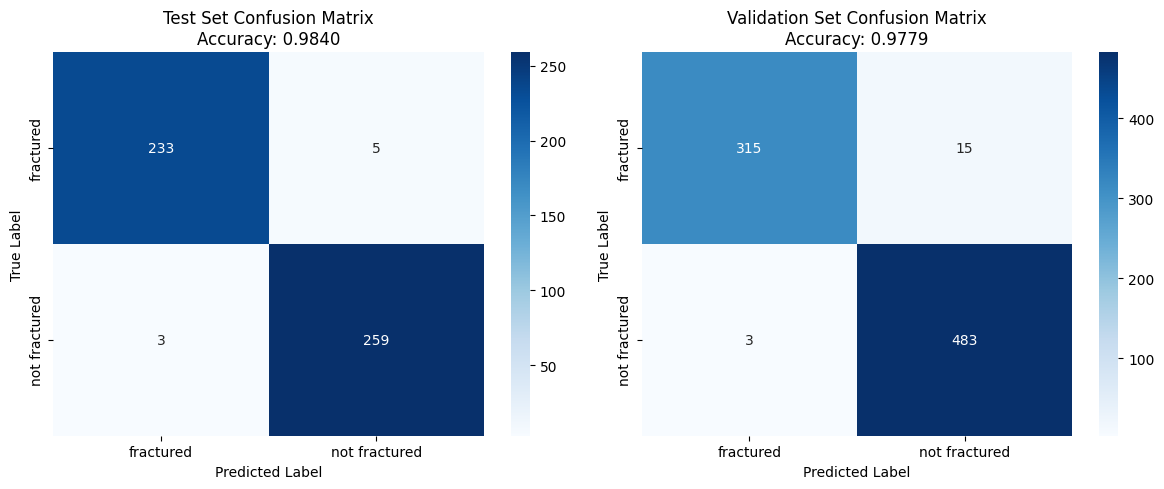

In [26]:
# Đánh giá mô hình
if 'best_svm' in locals():
    test_acc, val_acc = evaluate_model(best_svm, X_test_scaled, y_test_encoded,
                                      X_val_scaled, y_val_encoded)
else:
    print("Không có mô hình để đánh giá!")

In [27]:
# ===============================
# BƯỚC 8: CROSS-VALIDATION
# ===============================

print("\nThực hiện Cross-Validation...")
cv_scores = cross_val_score(best_svm, X_train_scaled, y_train_encoded, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Thực hiện Cross-Validation...
Cross-Validation Scores: [0.9804878  0.98373984 0.98211382 0.98753388 0.98535792]
Mean CV Score: 0.9838 (+/- 0.0049)



PHÂN TÍCH FEATURE IMPORTANCE
Model type: SGDClassifier
Đây là Linear model (SGD/LogisticRegression) - phân tích weights...


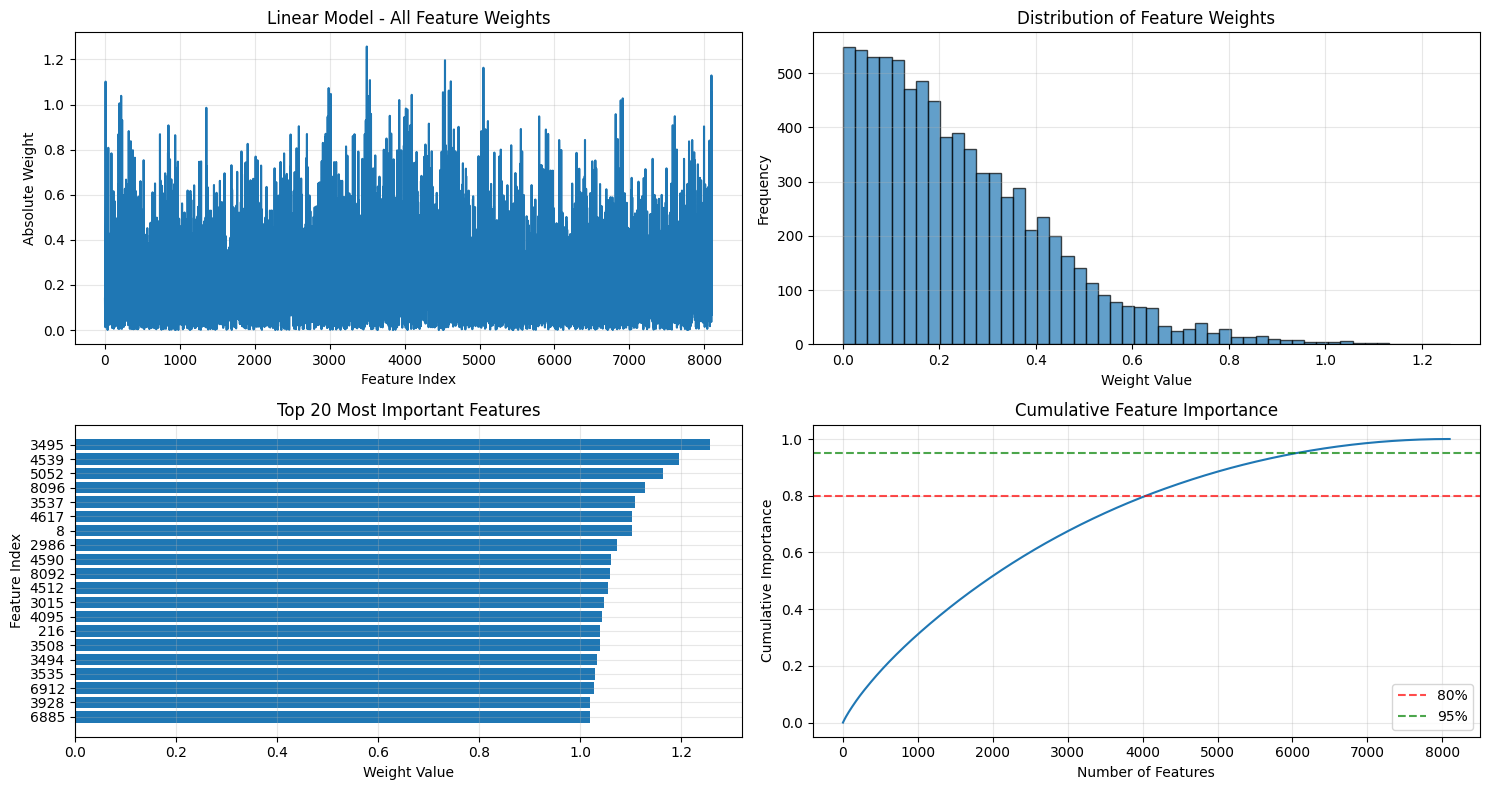


THỐNG KÊ FEATURE IMPORTANCE:
- Tổng số features: 8100
- Weight trung bình: 0.241248
- Weight std: 0.187417
- Weight max: 1.257406
- Weight min: 0.000061

TOP 10 FEATURES QUAN TRỌNG NHẤT:
 1. Feature 3495: 1.257406
 2. Feature 4539: 1.196582
 3. Feature 5052: 1.163261
 4. Feature 8096: 1.129072
 5. Feature 3537: 1.108438
 6. Feature 4617: 1.102970
 7. Feature    8: 1.101703
 8. Feature 2986: 1.073183
 9. Feature 4590: 1.061974
10. Feature 8092: 1.058256

FEATURE SELECTION INSIGHTS:
- Cần 4045 features để đạt 80% importance
- Cần 6046 features để đạt 95% importance
- Có thể loại bỏ 2054 features ít quan trọng


In [28]:
# ===============================
# BƯỚC 9: PHÂN TÍCH FEATURE IMPORTANCE (SỬA LỖI)
# ===============================

def analyze_feature_importance(model, feature_names=None):
    """
    Phân tích Feature Importance cho các loại model khác nhau
    """
    print(f"\n{'='*50}")
    print(f"PHÂN TÍCH FEATURE IMPORTANCE")
    print(f"Model type: {type(model).__name__}")
    print(f"{'='*50}")

    try:
        # Kiểm tra loại model và xử lý phù hợp
        if hasattr(model, 'kernel') and model.kernel == 'linear':
            # Linear SVM (SVC)
            print("Đây là Linear SVM - phân tích weights...")
            feature_weights = np.abs(model.coef_[0])
            model_type = "Linear SVM"

        elif hasattr(model, 'coef_') and not hasattr(model, 'kernel'):
            # SGDClassifier hoặc Linear models khác
            print("Đây là Linear model (SGD/LogisticRegression) - phân tích weights...")
            feature_weights = np.abs(model.coef_[0])
            model_type = "Linear Model"

        elif hasattr(model, 'feature_importances_'):
            # Random Forest hoặc tree-based models
            print("Đây là tree-based model - phân tích feature importances...")
            feature_weights = model.feature_importances_
            model_type = "Tree-based Model"

        elif hasattr(model, 'kernel') and model.kernel != 'linear':
            # Non-linear SVM
            print("Đây là Non-linear SVM - không thể phân tích feature importance trực tiếp.")
            print("Gợi ý: Sử dụng SHAP hoặc LIME để phân tích.")
            return None

        else:
            print("Model không hỗ trợ phân tích feature importance.")
            print(f"Available attributes: {[attr for attr in dir(model) if not attr.startswith('_')]}")
            return None

        # Vẽ biểu đồ feature weights
        plt.figure(figsize=(15, 8))

        # Subplot 1: All features
        plt.subplot(2, 2, 1)
        plt.plot(feature_weights)
        plt.title(f'{model_type} - All Feature Weights')
        plt.xlabel('Feature Index')
        plt.ylabel('Absolute Weight')
        plt.grid(True, alpha=0.3)

        # Subplot 2: Distribution of weights
        plt.subplot(2, 2, 2)
        plt.hist(feature_weights, bins=50, alpha=0.7, edgecolor='black')
        plt.title('Distribution of Feature Weights')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        # Subplot 3: Top 20 features
        top_20_indices = np.argsort(feature_weights)[-20:]
        top_20_weights = feature_weights[top_20_indices]

        plt.subplot(2, 2, 3)
        plt.barh(range(len(top_20_weights)), top_20_weights)
        plt.title('Top 20 Most Important Features')
        plt.xlabel('Weight Value')
        plt.ylabel('Feature Index')
        plt.yticks(range(len(top_20_weights)), top_20_indices)
        plt.grid(True, alpha=0.3)

        # Subplot 4: Cumulative importance
        sorted_weights = np.sort(feature_weights)[::-1]
        cumulative_weights = np.cumsum(sorted_weights) / np.sum(sorted_weights)

        plt.subplot(2, 2, 4)
        plt.plot(cumulative_weights)
        plt.title('Cumulative Feature Importance')
        plt.xlabel('Number of Features')
        plt.ylabel('Cumulative Importance')
        plt.grid(True, alpha=0.3)

        # Add line at 80% and 95%
        plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80%')
        plt.axhline(y=0.95, color='g', linestyle='--', alpha=0.7, label='95%')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Thống kê chi tiết
        print(f"\nTHỐNG KÊ FEATURE IMPORTANCE:")
        print(f"- Tổng số features: {len(feature_weights)}")
        print(f"- Weight trung bình: {np.mean(feature_weights):.6f}")
        print(f"- Weight std: {np.std(feature_weights):.6f}")
        print(f"- Weight max: {np.max(feature_weights):.6f}")
        print(f"- Weight min: {np.min(feature_weights):.6f}")

        # Top features
        print(f"\nTOP 10 FEATURES QUAN TRỌNG NHẤT:")
        top_10_indices = np.argsort(feature_weights)[-10:][::-1]
        for i, idx in enumerate(top_10_indices, 1):
            print(f"{i:2d}. Feature {idx:4d}: {feature_weights[idx]:.6f}")

        # Features cần thiết để đạt 80% và 95% importance
        n_features_80 = np.where(cumulative_weights >= 0.8)[0][0] + 1
        n_features_95 = np.where(cumulative_weights >= 0.95)[0][0] + 1

        print(f"\nFEATURE SELECTION INSIGHTS:")
        print(f"- Cần {n_features_80} features để đạt 80% importance")
        print(f"- Cần {n_features_95} features để đạt 95% importance")
        print(f"- Có thể loại bỏ {len(feature_weights) - n_features_95} features ít quan trọng")

        return {
            'weights': feature_weights,
            'top_indices': top_20_indices,
            'n_features_80': n_features_80,
            'n_features_95': n_features_95
        }

    except Exception as e:
        print(f"Lỗi khi phân tích feature importance: {e}")
        print("Chi tiết model:")
        print(f"- Type: {type(model)}")
        print(f"- Attributes: {[attr for attr in dir(model) if not attr.startswith('_') and not callable(getattr(model, attr))]}")
        return None
if 'best_svm' in locals():
    feature_analysis = analyze_feature_importance(best_svm)
else:
    print("Không tìm thấy model 'best_svm'. Hãy chạy lại bước huấn luyện.")

In [29]:
# ===============================
# BONUS: PHÂN TÍCH CHI TIẾT HƠN
# ===============================

def advanced_feature_analysis(model, X_train, y_train):
    """
    Phân tích nâng cao cho Linear models
    """
    if not (hasattr(model, 'coef_') or (hasattr(model, 'kernel') and model.kernel == 'linear')):
        print("Model không phù hợp cho phân tích nâng cao.")
        return

    print(f"\n{'='*50}")
    print("PHÂN TÍCH NÂNG CAO")
    print(f"{'='*50}")

    # Lấy weights
    weights = model.coef_[0] if hasattr(model, 'coef_') else model.coef_[0]

    # Phân tích theo từng class (nếu binary classification)
    if len(np.unique(y_train)) == 2:
        positive_features = np.where(weights > 0)[0]
        negative_features = np.where(weights < 0)[0]

        print(f"Features ảnh hưởng POSITIVE (class 1): {len(positive_features)}")
        print(f"Features ảnh hưởng NEGATIVE (class 0): {len(negative_features)}")

        # Top positive và negative features
        top_positive = positive_features[np.argsort(weights[positive_features])[-5:]]
        top_negative = negative_features[np.argsort(weights[negative_features])[:5]]

        print(f"\nTop 5 Positive Features:")
        for i, idx in enumerate(top_positive[::-1], 1):
            print(f"{i}. Feature {idx}: {weights[idx]:.6f}")

        print(f"\nTop 5 Negative Features:")
        for i, idx in enumerate(top_negative, 1):
            print(f"{i}. Feature {idx}: {weights[idx]:.6f}")

    # Correlation với target (nếu có thể)
    try:
        feature_target_corr = []
        for i in range(X_train.shape[1]):
            corr = np.corrcoef(X_train[:, i], y_train)[0, 1]
            if not np.isnan(corr):
                feature_target_corr.append((i, corr, weights[i]))

        # Sort by correlation
        feature_target_corr.sort(key=lambda x: abs(x[1]), reverse=True)

        print(f"\nTOP 10 FEATURES có CORRELATION cao nhất với target:")
        print("Feature | Correlation | Weight")
        print("-" * 35)
        for i, (feat_idx, corr, weight) in enumerate(feature_target_corr[:10], 1):
            print(f"{feat_idx:6d} | {corr:10.4f} | {weight:8.4f}")

    except Exception as e:
        print(f"Cannot calculate correlation: {e}")

# Chạy phân tích nâng cao
if 'best_svm' in locals() and 'X_train_scaled' in locals():
    try:
        advanced_feature_analysis(best_svm, X_train_scaled, y_train_encoded)
    except Exception as e:
        print(f"Không thể chạy phân tích nâng cao: {e}")
else:
    print("Thiếu dữ liệu để chạy phân tích nâng cao.")

print("\n✅ Phân tích Feature Importance hoàn thành!")


PHÂN TÍCH NÂNG CAO
Features ảnh hưởng POSITIVE (class 1): 3931
Features ảnh hưởng NEGATIVE (class 0): 4169

Top 5 Positive Features:
1. Feature 5052: 1.163261
2. Feature 216: 1.038683
3. Feature 6912: 1.027461
4. Feature 3928: 1.020037
5. Feature 6885: 1.018627

Top 5 Negative Features:
1. Feature 3495: -1.257406
2. Feature 4539: -1.196582
3. Feature 8096: -1.129072
4. Feature 3537: -1.108438
5. Feature 4617: -1.102970

TOP 10 FEATURES có CORRELATION cao nhất với target:
Feature | Correlation | Weight
-----------------------------------
  3505 |    -0.2498 |  -0.6290
  3532 |    -0.2383 |  -0.6242
  2464 |    -0.2356 |  -0.6117
  3004 |    -0.2264 |  -0.3006
  4630 |    -0.2263 |  -0.7722
  3038 |    -0.2185 |  -0.4906
  4072 |    -0.2150 |  -0.1852
  4120 |    -0.2123 |  -0.3347
  4119 |    -0.2115 |  -0.5678
  4324 |     0.2103 |   0.9154

✅ Phân tích Feature Importance hoàn thành!


In [30]:
# ===============================
# BƯỚC 10: HÀM DỰ ĐOÁN CHO ẢNH MỚI
# ===============================

# The original predict_fracture function is now less necessary as predict_fracture_optimized handles PCA.
# Let's update the test loop to use the optimized function and handle the possibility of no probability.

print("\nTest dự đoán trên một số ảnh từ test set:")
for i in [0, 1, 2, 3, 4]:
    if i < len(y_test):
        # Simulate getting the i-th test image path (replace with real path if needed)
        # For testing purposes, we can directly use the scaled features and label
        # from the loaded test set if a real image path isn't readily available.
        # However, the predict_fracture_optimized function expects an image path.
        # Let's create a dummy path or modify the test logic to use preloaded data for demonstration.

        # Using the preloaded scaled data for testing the model directly:
        if 'best_svm' in locals() and 'X_test_scaled' in locals() and len(X_test_scaled) > i:
             actual_label = label_encoder.inverse_transform([y_test_encoded[i]])[0] # Use encoded label if test set is encoded
             # Apply PCA if the final model used PCA
             X_test_sample = X_test_scaled[i:i+1]
             if pca_transformer is not None:
                 X_test_sample = pca_transformer.transform(X_test_sample)

             # Predict using the final chosen model
             predicted_encoded = best_svm.predict(X_test_sample)[0]
             predicted_label = label_encoder.inverse_transform([predicted_encoded])[0]

             # Get probability if the model supports it
             probability = None
             if hasattr(best_svm, 'predict_proba'):
                 try:
                     probability = best_svm.predict_proba(X_test_sample)[0]
                 except AttributeError:
                      probability = None # Fallback if predict_proba exists but errors

             print(f"Ảnh {i+1}: Thực tế = {actual_label}, Dự đoán = {predicted_label}")
             if probability is not None:
                 # Map probabilities back to class names
                 proba_dict = dict(zip(label_encoder.classes_, probability))
                 # Sort probabilities by class names for consistent output (optional)
                 sorted_proba_dict = {k: proba_dict[k] for k in sorted(proba_dict)}
                 print(f"  Xác suất: {sorted_proba_dict}")
             else:
                 print("  (Xác suất không khả dụng cho mô hình này)")

        elif 'best_svm' not in locals():
            print("Không tìm thấy mô hình 'best_svm'. Bỏ qua test dự đoán.")
            break # Stop the loop if model is not available
        else:
             print(f"Không đủ dữ liệu test để test ảnh thứ {i+1}.")


Test dự đoán trên một số ảnh từ test set:
Ảnh 1: Thực tế = fractured, Dự đoán = fractured
  (Xác suất không khả dụng cho mô hình này)
Ảnh 2: Thực tế = fractured, Dự đoán = fractured
  (Xác suất không khả dụng cho mô hình này)
Ảnh 3: Thực tế = fractured, Dự đoán = fractured
  (Xác suất không khả dụng cho mô hình này)
Ảnh 4: Thực tế = fractured, Dự đoán = fractured
  (Xác suất không khả dụng cho mô hình này)
Ảnh 5: Thực tế = fractured, Dự đoán = fractured
  (Xác suất không khả dụng cho mô hình này)


In [31]:
# ===============================
# BƯỚC 11: LƯU MÔ HÌNH
# ===============================

import joblib

# Lưu mô hình và các components
model_components = {
    'model': best_svm,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'target_size': (128, 128)
}

joblib.dump(model_components, 'bone_fracture_svm_model.pkl')
print("\nMô hình đã được lưu thành công vào 'bone_fracture_svm_model.pkl'")


Mô hình đã được lưu thành công vào 'bone_fracture_svm_model.pkl'



TỔNG KẾT KẾT QUẢ PHÂN LOẠI XƯƠNG GÃY
Dataset: Bone Fracture Binary Classification
Phương pháp: SVM + HOG Features
Số lượng train samples: 9224
Số lượng test samples: 500
Số lượng validation samples: 816
Số đặc trưng HOG: 8100
Tham số mô hình cuối cùng (SGDClassifier): {'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': True, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'adaptive', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 10, 'n_jobs': -1, 'penalty': 'l2', 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Test Accuracy: 0.9840
Validation Accuracy: 0.9779
Cross-Validation Score: 0.9838 ± 0.0049


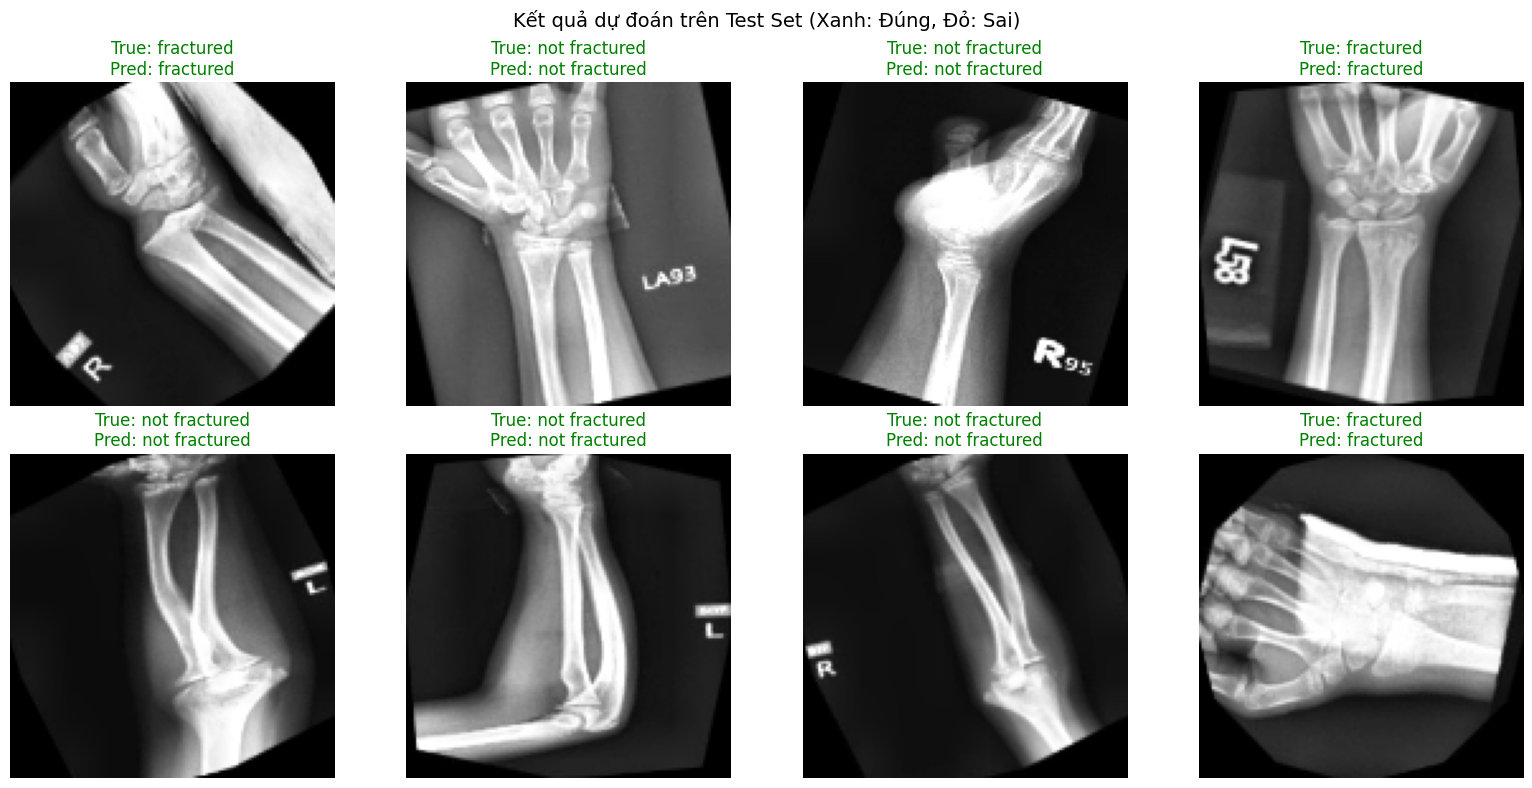


Hoàn thành! Mô hình SVM với HOG features đã được huấn luyện và đánh giá.
Bạn có thể sử dụng hàm predict_fracture() để dự đoán trên ảnh mới.


In [33]:
# ===============================
# TÓNG KẾT KẾT QUẢ
# ===============================

print(f"\n{'='*60}")
print(f"TỔNG KẾT KẾT QUẢ PHÂN LOẠI XƯƠNG GÃY")
print(f"{'='*60}")
print(f"Dataset: Bone Fracture Binary Classification")
print(f"Phương pháp: SVM + HOG Features")
print(f"Số lượng train samples: {len(X_train_scaled)}")
print(f"Số lượng test samples: {len(X_test_scaled)}")
print(f"Số lượng validation samples: {len(X_val_scaled)}")
print(f"Số đặc trưng HOG: {X_train_scaled.shape[1]}")

# Kiểm tra loại mô hình trước khi truy cập thuộc tính
if 'best_svm' in locals():
    if hasattr(best_svm, 'best_params_'): # Check if it's a search object
        print(f"Tham số SVM tốt nhất (từ RandomizedSearchCV): {best_svm.best_params_}")
    elif hasattr(best_svm, 'get_params'): # Get parameters of the final model (e.g., SGDClassifier or final SVC)
         print(f"Tham số mô hình cuối cùng ({type(best_svm).__name__}): {best_svm.get_params()}")
    else:
        print("Không thể hiển thị tham số mô hình.")
else:
    print("Mô hình cuối cùng chưa được định nghĩa.")


print(f"Test Accuracy: {test_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Cross-Validation Score: {cv_scores.mean():.4f} ± {cv_scores.std() * 2:.4f}") # Adjusted std range to 2*std
print(f"{'='*60}")

# Hiển thị một số ảnh test với dự đoán
def show_predictions(n_samples=8):
    """Hiển thị dự đoán trên một số ảnh test"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    # Lấy ngẫu nhiên một số ảnh
    indices = np.random.choice(len(X_test_images), n_samples, replace=False)

    for i, idx in enumerate(indices):
        # Dự đoán
        # Ensure PCA transformation is applied if needed before prediction
        X_test_sample = X_test_scaled[idx:idx+1]
        if 'pca_transformer' in globals() and pca_transformer is not None:
            X_test_sample = pca_transformer.transform(X_test_sample)

        pred_encoded = best_svm.predict(X_test_sample)[0] # Predict returns encoded label
        pred_label = label_encoder.inverse_transform([pred_encoded])[0]
        actual_label = y_test[idx] # y_test is the original string label

        # Màu sắc: xanh nếu đúng, đỏ nếu sai
        color = 'green' if pred_label == actual_label else 'red'

        axes[i].imshow(X_test_images[idx], cmap='gray')
        axes[i].set_title(f'True: {actual_label}\nPred: {pred_label}', color=color)
        axes[i].axis('off')

    plt.suptitle('Kết quả dự đoán trên Test Set (Xanh: Đúng, Đỏ: Sai)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Only call show_predictions if there's test data and a model
if 'best_svm' in locals() and 'X_test_images' in locals() and len(X_test_images) > 0:
    show_predictions()
else:
    print("Không có dữ liệu test hoặc mô hình để hiển thị dự đoán.")


print("\nHoàn thành! Mô hình SVM với HOG features đã được huấn luyện và đánh giá.")
print("Bạn có thể sử dụng hàm predict_fracture() để dự đoán trên ảnh mới.")